In [1]:
from random import random
from time import process_time_ns

from TsMon import TsMon
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt


def euclidean_distance(seq1, seq2):
    # 确保序列长度相同
    if len(seq1) != len(seq2):
        raise ValueError("序列长度必须相同")

    # 转换为 numpy 数组并计算欧氏距离
    seq1 = np.array(seq1)
    seq2 = np.array(seq2)
    return np.sqrt(np.sum((seq1 - seq2) ** 2))


def cosine_similarity(seq1, seq2):
    # 确保序列长度相同
    if len(seq1) != len(seq2):
        raise ValueError("序列长度必须相同")

    # 转换为 numpy 数组
    seq1 = np.array(seq1, dtype=np.int64)
    seq2 = np.array(seq2, dtype=np.int64)

    # 计算点积
    dot_product = np.dot(seq1, seq2)

    # 计算模长
    norm1 = np.sqrt(np.sum(seq1 ** 2))
    norm2 = np.sqrt(np.sum(seq2 ** 2))

    # 避免除以零
    if norm1 == 0 or norm2 == 0:
        return 0.0

    # 计算余弦相似度
    return dot_product / (norm1 * norm2)


def average_relative_error(seq1, seq2):
    # 确保序列长度相同
    if len(seq1) != len(seq2):
        raise ValueError("序列长度必须相同")

    # 转换为 numpy 数组并确保浮点数类型
    seq1 = np.array(seq1, dtype=np.float64)
    seq2 = np.array(seq2, dtype=np.float64)

    # 计算绝对误差
    abs_error = np.abs(seq1 - seq2)

    # 计算相对误差（避免除以零）
    relative_error = np.divide(abs_error, np.abs(seq1), out=np.zeros_like(abs_error), where=seq1 != 0)

    # 计算平均相对误差
    return np.mean(relative_error)


def energy_similarity(f, f_hat):
    # 确保序列长度相同
    if len(f) != len(f_hat):
        raise ValueError("序列长度必须相同")

    # 转换为 numpy 数组并确保浮点数类型
    f = np.array(f, dtype=np.float64)
    f_hat = np.array(f_hat, dtype=np.float64)

    # 计算能量（平方和的平方根）
    energy_f = np.sqrt(np.sum(f ** 2))
    energy_f_hat = np.sqrt(np.sum(f_hat ** 2))

    # 避免除以零
    if energy_f == 0 or energy_f_hat == 0:
        return 0.0

    # 根据公式计算相似度
    if energy_f <= energy_f_hat:
        return energy_f / energy_f_hat
    else:
        return energy_f_hat / energy_f


def count_packets_by_key(packets, window_size, target_key):
    if not packets:
        return []

    # 获取所有时间戳以确定范围
    all_timestamps = []
    for key, bits, timestamp, _ in packets:
        if key == target_key:
            all_timestamps.append(timestamp)
    if not all_timestamps:
        return []

    min_time = min(all_timestamps)
    max_time = max(all_timestamps)

    # 计算窗口数量
    num_windows = int((max_time - min_time) // window_size) + 1

    # 初始化计数数组
    counters = [0] * num_windows

    # 统计 key=2 的数据包
    for key, bits, time, _ in packets:
        if key == target_key:
            # 计算窗口索引
            window_index = int((time - min_time) // window_size)
            if 0 <= window_index < num_windows:
                counters[window_index] += bits

    return counters


def count_all_packets_by_key(packets, window_size):
    # 初始化 defaultdict 用于存储每个 key 的时间戳
    temp_sequence = defaultdict(list)
    p_bits = {}

    # 按 key 收集时间戳
    for key, bits, timestamp, _ in packets:
        temp_sequence[key].append(timestamp)
        p_bits[key] = bits

    # 初始化输出 defaultdict
    rawsequence = defaultdict(list)

    # 对每个 key 单独处理
    for key, timestamps in temp_sequence.items():
        if not timestamps:
            continue

        # 获取该 key 的时间范围
        min_time = min(timestamps)
        max_time = max(timestamps)

        # 计算该 key 的窗口数量
        num_windows = int((max_time - min_time) // window_size) + 1

        # 初始化计数数组
        counters = [0] * num_windows

        # 统计包数
        for time in timestamps:
            window_index = int((time - min_time) // window_size)
            if 0 <= window_index < num_windows:
                counters[window_index] += p_bits[key]

        # 存储到 rawsequence
        rawsequence[key] = counters

    return rawsequence

In [4]:
DATA = './new_NB15_to_title.csv'
windowSize = 10_000
queue_length = 8
flowNum = 68537 # 68537

'''
Raw packets
'''
packets = []
with open(DATA, 'r') as f:
    for line in f:
        key, p_bits, global_time, label = line.strip().split(',')
        key = int(key)
        global_time = int(global_time)
        label = int(label)
        p_bits = int(p_bits)
        packets.append((key, p_bits, global_time, label))

# ano_info = [[] for x in range(100000)]
# for packet in packets:
#     key, p_bits, global_time, label = packet
#     if label == 1:
#         ano_info[key].append(global_time)

ts_mon = TsMon(6, 40960, 1024, queue_length, windowSize)



In [2]:
DATA = './Branch/Datasets/MAWI_input_t.csv'
windowSize = 100_000
queue_length = 8
flowNum = 1387705

'''
Raw packets
'''
packets = []
with open(DATA, 'r') as f:
    next(f)
    for line in f:
        key, p_bits, global_time, label = line.strip().split(',')

        key = int(key)
        global_time = int(global_time)
        label = int(label)
        p_bits = int(p_bits)
        packets.append((key, p_bits, global_time, label))

# ano_info = [[] for x in range(100000)]
# for packet in packets:
#     key, p_bits, global_time, label = packet
#     if label == 1:
#         ano_info[key].append(global_time)

ts_mon = TsMon(3, 277, 1, queue_length, windowSize)



In [65]:
'''
运行 TsSketch test
'''
for packet in packets:
    key, p_bits, global_time, label = packet
    ts_mon.TsSketch_test(key, p_bits, global_time)


In [ ]:
'''
运行 TsMon
'''

for packet in packets:
    key, p_bits, global_time, label = packet
    ts_mon.process(key, p_bits, global_time)

'''
Pop up residual data
'''
# ts_mon.popout_residual_data(flowNum)


In [66]:
'''
Perfect traffic statistics method
'''

from collections import defaultdict
interval = 100_000


def packets_to_flow(flowNum, packets, interval):
    timeNow = 0

    replay = [[] for x in range(flowNum)]
    stStorage = defaultdict(int)

    for p in packets:
        flowKey, pBits, pTimeStamp, label = p
        if pTimeStamp - timeNow >= interval:
            for key, val in stStorage.items():
                replay[key].append((timeNow, val))

            stStorage = defaultdict(int)
            timeNow = (pTimeStamp // interval) * interval

        stStorage[flowKey] += pBits

    '''
    pop out all data at the end
    '''
    for key, val in stStorage.items():
        replay[key].append((timeNow, val))

    return replay

no_error_replay = packets_to_flow(flowNum, packets, interval)



0.7299282156811048 0.7893262622115266 32.39441174302242 617


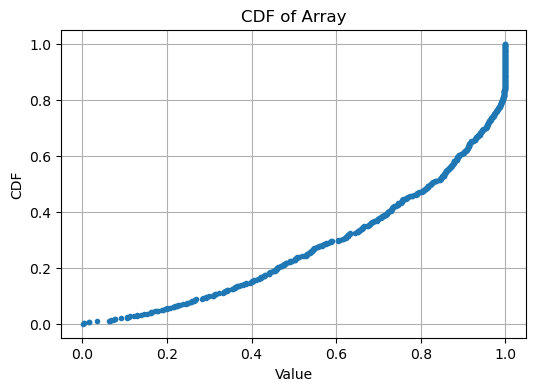

In [67]:
'''
精度计算
'''
arr = []

cos = 0
energy = 0
are = 0
count = 0
for flowID in range(1, flowNum):
    if len(ts_mon.traffic[flowID]) == 0:
        continue
    else:
        count += 1
    _, y_tsmon = zip(*ts_mon.traffic[flowID])
    _, y_raw = zip(*no_error_replay[flowID])
    minLen = min(len(y_tsmon), len(y_raw))


    temp = cosine_similarity(y_tsmon[:minLen], y_raw[:minLen])
    cos += temp
    arr.append((flowID, temp))
    energy += energy_similarity(y_tsmon[:minLen], y_raw[:minLen])
    are += average_relative_error(y_tsmon[:minLen], y_raw[:minLen])
    # print(average_relative_error(y_tsmon[:minLen], y_raw[:minLen]), y_tsmon[:minLen], y_raw[:minLen], flowID)

cos /= count
energy /= count
are /= count
print(cos, energy, are, count)

import numpy as np
import matplotlib.pyplot as plt

# 示例数组
_, b = zip(*arr)


# 排序
data = np.sort(b)

# 计算CDF
y = np.arange(1, len(data) + 1) / len(data)

# 绘制CDF
plt.figure(figsize=(6,4))
plt.plot(data, y, marker='.', linestyle='none')
plt.xlabel('Value')
plt.ylabel('CDF')
plt.title('CDF of Array')
plt.grid(True)
plt.show()

In [ ]:
'''
获得 TsMon 示意图
'''
targetFlow = ts_mon.replay[800]
# print(targetFlow)
x_tsmon, y_tsmon = zip(*targetFlow)
# x_tsmon = range(len(y_tsmon))

# 绘制折线图
plt.figure(figsize=(24, 6))
plt.plot(x_tsmon, y_tsmon, marker='o')
# plt.xlim(0, 1000000)
plt.show()

In [ ]:
'''
原数据示意图
'''
x_raw, y_raw = zip(*no_error_replay[800])

# 绘制折线图
plt.figure(figsize=(24, 6))
plt.plot(x_raw, y_raw, marker='o')
# plt.xlim(0, 1000000000)
plt.show()

In [ ]:
'''
ARE calculation
'''

cos = 0
energy = 0
are = 0
count = 0
for flowID in range(1, flowNum):
    if len(ts_mon.replay[flowID]) == 0:
        count += 1
        continue
    _, y_tsmon = zip(*ts_mon.replay[flowID])
    _, y_raw = zip(*no_error_replay[flowID])
    minLen = min(len(y_tsmon), len(y_raw))

    cos += cosine_similarity(y_tsmon[:minLen], y_raw[:minLen])
    energy += energy_similarity(y_tsmon[:minLen], y_raw[:minLen])
    are += average_relative_error(y_tsmon[:minLen], y_raw[:minLen])
    # print(average_relative_error(y_tsmon[:minLen], y_raw[:minLen]), y_tsmon[:minLen], y_raw[:minLen], flowID)

cos /= flowNum - count
energy /= flowNum - count
are /= flowNum - count
print(cos, energy, are, count)

In [ ]:
'''
分割线----------------------------------------------------------------------------------------------------------------------
'''

In [ ]:
'''
Get raw time series data
Processing ts_mon time series data
'''

# raw_sequences = count_all_packets_by_key(packets, window_size=windowSize)
raw_sequences = ts_mon.cms_value

for flow_id in raw_sequences:
    f = ts_mon.popout(flow_id)
    for x in list(f):
        if x == 0: continue
        ts_mon.re_values.append({flow_id: x})
        if flow_id == target_key:
            ts_mon.plt_values.append(x)

In [ ]:
counters = count_packets_by_key(packets, windowSize, target_key=target_key)
# counters = raw_sequences[target_key]
ts_mon.plt_values = [x for x in
                     ts_mon.plt_values[ts_mon.plt_values.index(next(filter(lambda x: x != 0, ts_mon.plt_values))):]]
plt.figure(figsize=(24, 6))
plt.xlim(-1, max(len(counters[:]), len(ts_mon.plt_values)))
plt.plot(counters[:], color='b', label='Raw')
# plt.plot(ts_mon.plt_values[:], color='g', label='TsMon', alpha=0.7)
plt.legend()
plt.show()

print(cosine_similarity(counters[:len(ts_mon.plt_values)], ts_mon.plt_values[:len(counters)]))


In [ ]:
'''
Result - data flows reconstruction
'''

sequences = defaultdict(list)
for item in ts_mon.re_values:
    for flow_id, count in item.items():
        sequences[flow_id].append(count)

# for flow in sequences:
#     sequences[flow] = sequences[flow][1:]

# keys_to_delete = []
# for flow_id in sequences:
#     # sequences[flow_id] = sequences[flow_id][1:]
#     # seq = sequences[flow_id]
#     # # 去除前导零
#     # start = next((i for i, x in enumerate(seq) if x != 0), len(seq))
#     # sequences[flow_id] = seq[start:]
#     # # 去除后导零
#     # end = next((len(seq) - i - 1 for i, x in enumerate(reversed(seq)) if x != 0), -1) + 1
#     # sequences[flow_id] = seq[:end]
#     # 如果序列为空，标记该键删除
#     if not sequences[flow_id]:
#         keys_to_delete.append(flow_id)


# 删除全零或空序列的键
# for flow_id in keys_to_delete:
#     del sequences[flow_id]


cdf_cos = []
avg_ARE = 0
avg_cos = 0
avg_eng = 0

i = 0

for flow_id in sequences:
    if len(sequences[flow_id]) == 0 or len(raw_sequences[flow_id]) == 0: continue
    i += 1
    # print(len(sequences[flow_id]), len(raw_sequences[flow_id]))
    # print(flow_id)
    # print(sequences[flow_id], raw_sequences[flow_id], sep='\n')
    leng = min(len(raw_sequences[flow_id]), len(sequences[flow_id]))
    avg_ARE += average_relative_error(sequences[flow_id][:leng], raw_sequences[flow_id][:leng])
    avg_cos += cosine_similarity(sequences[flow_id][:leng], raw_sequences[flow_id][:leng])
    cdf_cos.append(cosine_similarity(sequences[flow_id][:leng], raw_sequences[flow_id][:leng]))
    avg_eng += energy_similarity(sequences[flow_id][:leng], raw_sequences[flow_id][:leng])

avg_ARE /= i
avg_cos /= i
avg_eng /= i

# np.save('websearch.npy', cdf_cos)

print(avg_ARE, avg_cos, avg_eng)

In [ ]:
from cycler import cycler
import random as rand

# 设置图表风格为论文品质
plt.style.use('seaborn-v0_8-whitegrid')

# 自定义颜色循环（更适合区分）
colors = ['#1f77b4', '#feca31', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
plt.rcParams['axes.prop_cycle'] = cycler('color', colors)

# 增加默认图表大小和DPI（适合论文）
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# 增加线条宽度和标记大小
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 5

# 增加字体大小
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

target = 51
output = [[[] for j in range(2)] for x in range(10000)]

for index, i in enumerate(ts_mon.re_values):
    for key, x in i.items():
        if key == target:
            # output[key][0].append(index)
            output[key][1].append(x)

np.save('output_5.npy', output[target][1])
np.save('raw_5.npy', raw_sequences[target])

# plt.plot(range(len(output[target][1])-1), [abs(x/100) for x in output[target][1][:-1] ], color='#1f77b4', alpha=1, label='TsMon', linestyle='-')
# plt.scatter(range(len(raw_sequences[target])), [abs(x/100) for x in raw_sequences[target][:]], color='#ff6c0e', label='Raw Flows', s=5)


# plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from cycler import cycler

# 设置图表风格为论文品质
plt.style.use('seaborn-v0_8-whitegrid')

# 自定义颜色循环（更适合区分）
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

color_style = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                            '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])
plt.rcParams['axes.prop_cycle'] = cycler('color', colors)
# plt.rc('axes', prop_cycle=cycler('color', colors))

# 增加默认图表大小和DPI（适合论文）
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# 增加线条宽度和标记大小
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 5

# 增加字体大小
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# 数据


# 方法1：使用 sharex=True 参数
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# 第一个子图
# plt.plot(range(5,len(output[i][1])), output[i][1][5:], color='#1f77b4', alpha=1, label='TsMon', linestyle='-')
# plt.scatter(range(5,len(raw_sequences[i])), raw_sequences[i][5:], color='#ff6c0e', label='Raw Flows', s=5)

axes[0].plot([1, 2, 3], [1, 2, 3], linestyle='-', marker='.', markersize=5)
# axes[0].set_xlabel("Cosine Similarity", fontweight='bold')
# axes[0].set_ylabel("CDF", fontweight='bold')
# axes[0].text(0.5, -0.25, '(a) Hadoop', fontsize=12, fontdict={'family': 'Times New Roman'}, ha='center', fontweight='bold')
#
# # 第二个子图

# axes[1].plot(data_sorted_b, cdf_b, linestyle='-', marker='.', markersize=5)
# axes[1].set_xlabel("Cosine Similarity", fontweight='bold')
# axes[1].set_ylabel("CDF", fontweight='bold')
# axes[1].text(0.5, -0.25, '(b) Websearch', fontsize=12, fontdict={'family': 'Times New Roman'}, ha='center', fontweight='bold')

# 调整子图间距
plt.tight_layout()
plt.savefig('./temp.pdf')

plt.show()

In [ ]:

data_sorted = np.sort(cdf_cos)

# 步骤2：计算CDF的y值（百分比）
cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

# 步骤3：画图
plt.plot(data_sorted, cdf, linestyle='-', marker='.', markersize=5)
plt.xlabel("Cosine Similarity", fontweight='bold')
plt.ylabel("CDF", fontweight='bold')
plt.text(0.5, -0.25, '(b) Websearch', fontsize=12, fontdict={'family': 'Times New Roman'}, ha='center',
         fontweight='bold')
# plt.title("CDF of Cosine Similarity for Reconstructed Flows")
plt.xlim([0, 1])
plt.grid(True)

plt.tight_layout()
# plt.savefig('./Figures/cdf_websearch.pdf')
plt.show()

In [ ]:
# '''
# chi-square test and Threshold
# '''

import time as Time

start = 0
end = 0
tflag = False

dTP = 0
dTN = 0
dFP = 0
dFN = 0
last = [0 for x in range(20000)]

select = []

TP = 0
TN = 0
FP = 0
FN = 0

from chi_square_test import IncrementalChiSquareZipf

detector = [IncrementalChiSquareZipf(zipf_param=1.0) for i in range(20000)]
for i, packet in enumerate(packets):

    key, bits, time, label = packet
    if tflag != True:
        start = Time.perf_counter_ns()
    chi2_stat, p_value, df = detector[key].update(bits)

    if tflag != True:
        end = Time.perf_counter_ns()
        tflag = True
        print(end - start)

    if i < len(packets) * 0.7:
        select.append(bits)

    if p_value < 0.02:
        if label == 1:
            TP += 1
        else:
            FP += 1
    else:
        if label == 1:
            FN += 1
        else:
            TN += 1

    if abs(bits - last[key]) >= 1000:
        if label == 1:
            dTP += 1
        else:
            dFP += 1
    else:
        if label == 1:
            dFN += 1
        else:
            dTN += 1

    last[key] = bits

gTP = 0
gTN = 0
gFP = 0
gFN = 0
# select = np.array(select)
std = np.std(select)
mean = np.mean(select)
upper = mean + 1 * std
lower = mean - 1 * std
for packet in packets:

    key, bits, time, label = packet
    if bits > upper or bits < lower:
        if label == 1:
            gTP += 1
        else:
            gFP += 1
    else:
        if label == 1:
            gFN += 1
        else:
            gTN += 1

print('卡方检验')
acc = (TP + TN) / (TP + TN + FP + FN)
print(acc)
precision = TP / (TP + FP)
print(precision)
recall = TP / (TP + FN)
print(recall)
print(2 * (precision * recall) / (precision + recall))

print('\n 全局标准差')
acc = (gTP + gTN) / (gTP + gTN + gFP + gFN)
print(acc)
precision = gTP / (gTP + gFP)
print(precision)
recall = gTP / (gTP + gFN)
print(recall)
print(2 * (precision * recall) / (precision + recall))

print('\n Difference approach')

acc = (dTP + dTN) / (dTP + dTN + dFP + dFN)
print(acc)
precision = dTP / (dTP + dFP)
print(precision)
recall = dTP / (dTP + dFN)
print(recall)
print(2 * (precision * recall) / (precision + recall))








In [ ]:
'''
Result - Anomaly detection
'''

TP = ts_mon.TP
TN = ts_mon.TN
FP = ts_mon.FP
FN = ts_mon.FN

acc = (TP + TN) / (TP + TN + FP + FN)
print(acc)
precision = TP / (TP + FP)
print(precision)
recall = TP / (TP + FN)
print(recall)
print(2 * (precision * recall) / (precision + recall))






In [ ]:
'''
naïve sketch
'''

interval = 1_000_000
flowNum = 68537
width = 8333
height = 3

timeLast = 0

sketch = [[0 for j in range(width)] for x in range(height)]
flowSet = set()
cms_replay = [[] for x in range(flowNum)]


def _hash(num):
    num1 = hash(str(num) + str(1)) % width
    num2 = hash(str(num) + str(2)) % width
    num3 = hash(str(num) + str(3)) % width
    return num1, num2, num3


for p in packets:
    flowKey, pBits, pTimeStamp, label = p
    '''
    超过间隔, 上传Sketch
    '''
    if pTimeStamp - timeLast > interval:
        '''
        遍历流集, 将数据更新至cms_replay中
        '''
        for flow in flowSet:
            hkey1, hkey2, hkey3 = _hash(flow)
            stVal = min(sketch[0][hkey1], sketch[1][hkey2], sketch[2][hkey3])
            cms_replay[flow].append((timeLast, stVal))

        '''
        重置sketch和flowSet, 更新timeLast为本窗口
        '''
        sketch = [[0 for j in range(width)] for x in range(height)]
        flowSet = set()
        timeLast = (pTimeStamp // interval) * interval

    '''
    更新Sketch
    '''
    hkey1, hkey2, hkey3 = _hash(flowKey)
    flowSet.add(flowKey)
    sketch[0][hkey1] += pBits
    sketch[1][hkey2] += pBits
    sketch[2][hkey3] += pBits










In [ ]:
x_sketch, y_sketch = zip(*cms_replay[1])  # 解包为两个元组：x = (x1, x2, ...), y = (y1, y2, ...)

# 绘制折线图
plt.figure(figsize=(24, 6))
plt.plot(x_sketch, y_sketch, marker='o')  # marker='o' 在点处显示圆点
# plt.xlim(0, 1000000)
plt.show()

In [ ]:
'''
Perfect traffic statistics method
'''

from collections import defaultdict

interval = 1_000_000
flowNum = 68537

def packets_to_flow(flowNum, packets, interval):
    timeNow = 0

    replay = [[] for x in range(flowNum)]
    stStorage = defaultdict(int)

    for p in packets:
        flowKey, pBits, pTimeStamp, label = p
        if pTimeStamp - timeNow >= interval:
            for key, val in stStorage.items():
                replay[key].append((timeNow, val))

            stStorage = defaultdict(int)
            timeNow = (pTimeStamp // interval) * interval

        stStorage[flowKey] += pBits

    '''
    pop out all data at the end
    '''
    for key, val in stStorage.items():
        replay[key].append((timeNow, val))

    return replay

no_error_replay = packets_to_flow(flowNum, packets, interval)



In [ ]:
x_raw, y_raw = zip(*no_error_replay[1])

# 绘制折线图
plt.figure(figsize=(24, 6))
plt.plot(x_raw, y_raw, marker='o')
# plt.xlim(0, 1000000000)
plt.show()

In [ ]:
'''
ARE calculation
'''

cos = 0
energy = 0
are = 0
count = 0
for flowID in range(1, flowNum):
    if len(ts_mon.replay[flowID]) == 0:
        count += 1
        continue
    _, y_tsmon = zip(*ts_mon.replay[flowID])
    _, y_raw = zip(*no_error_replay[flowID])
    minLen = min(len(y_tsmon), len(y_raw))

    cos += cosine_similarity(y_tsmon[:minLen], y_raw[:minLen])
    energy += energy_similarity(y_tsmon[:minLen], y_raw[:minLen])
    are += average_relative_error(y_tsmon[:minLen], y_raw[:minLen])

cos /= flowNum - count
energy /= flowNum - count
are /= flowNum - count
print(cos, energy, are, count)